In [1096]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests, ccf

import warnings
warnings.filterwarnings('ignore')

# Features

In [1206]:
era5_features = [
        # Temperature variables
        'temperature_2m',                       # Air temperature
        'temperature_2m_min',                   # Daily minimum air temperature
        'temperature_2m_max',                   # Daily maximum air temperature
        'soil_temperature_level_1',             # Topsoil temperature (0-7 cm)
        'soil_temperature_level_2',             # Soil temperature (7-28 cm)
        
        # Moisture variables
        'volumetric_soil_water_layer_1',        # Topsoil moisture content
        'volumetric_soil_water_layer_2',        # Soil moisture (7-28 cm)
        'volumetric_soil_water_layer_3',        # Soil moisture (28-100 cm)
        'total_precipitation_sum',              # Total rainfall and snow
        'dewpoint_temperature_2m',              # Air humidity indicator
        
        # Radiation and energy variables
        'surface_solar_radiation_downwards_sum', # Solar radiation at surface
        'surface_net_solar_radiation_sum',       # Net solar radiation at surface
        
        # Evaporation and water cycle
        'total_evaporation_sum',                 # Actual evaporation
        
        # Wind variables
        'u_component_of_wind_10m',               # East-west wind component
        'v_component_of_wind_10m'                # North-south wind component
    ]

openweather_features = [
        'temp',         # Current temperature (C or K depending on units)
        'feels_like',   # Perceived temperature considering humidity and wind (C or K)
        'temp_min',     # Minimum temperature at the moment (C or K)
        'temp_max',     # Maximum temperature at the moment (C or K)
        'pressure',     # Atmospheric pressure at sea level (hPa)
        'humidity',     # Humidity percentage (%)
        'wind_speed',   # Wind speed (meter/sec)
        'wind_deg',     # Wind direction in degrees (0–360)
        'rain_1h',      # Rain volume for the last 1 hour (mm)
        'rain_3h',      # Rain volume for the last 3 hours (mm)
        'clouds_all'    # Cloudiness percentage (%)
    ]

chirts_features = [
        'heat_index',
        'maximum_temperature',
        'minimum_temperature',
        'relative_humidity',
        'saturation_vapor_pressure',
        'vapor_pressure_deficit',
    ]

power_features = [
        'T2M',           # MERRA-2 Temperature at 2 Meters (C)
        'T2MDEW',        # MERRA-2 Dew/Frost Point at 2 Meters (C)
        'T2MWET',        # MERRA-2 Wet Bulb Temperature at 2 Meters (C)
        'TS',            # MERRA-2 Earth Skin Temperature (C)
        'T2M_RANGE',     # MERRA-2 Temperature at 2 Meters Range (C)
        'T2M_MAX',       # MERRA-2 Temperature at 2 Meters Maximum (C)
        'T2M_MIN',       # MERRA-2 Temperature at 2 Meters Minimum (C)
        'PS',            # MERRA-2 Surface Pressure (kPa)
        'WS2M',          # MERRA-2 Wind Speed at 2 Meters (m/s)
        'WS2M_MAX',      # MERRA-2 Wind Speed at 2 Meters Maximum (m/s)
        'WS2M_MIN',      # MERRA-2 Wind Speed at 2 Meters Minimum (m/s)
        'GWETTOP',       # MERRA-2 Surface Soil Wetness (1)
        'GWETROOT'      # MERRA-2 Root Zone Soil Wetness (1)
    ]

selected_features = era5_features

# Params

In [1303]:
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# konfigurasi parameter

selected_kec = 'cibeber'
selected_clim = 'era5'
viz_dir = "visualization/"
evi = True

outliers_threshold = 1.5
climate_dir = f"climate_timeseries/cleaned/{selected_clim}_{selected_kec}.csv"
vegetation_dir = f"pandanwangi_timeseries/{"evi_" if evi else ""}{selected_kec}.csv"
temporal_resolution = '5D'

extract_statistics = ['mean', 'min', 'max', 'std']

# Load Veg and Clim Data

In [1304]:
raw_veg_df = pd.read_csv(vegetation_dir)
start_year_grouping = 2018
end_year_grouping = 2024

## Functions

In [ ]:
def smoothing_sg(df, window_length=10, polyorder=3):
    for col in ['mean', 'min', 'max']:
        filtered = savgol_filter(df[col], window_length=window_length, polyorder=polyorder)
        df[f'smoothed_{col}'] = filtered
    return df

def moving_average(array, window_size=6):
    return pd.Series(array).rolling(window=window_size, center=True, min_periods=1).mean().to_numpy()

def remove_outliers(array):
    array = np.array(array, dtype=float)
    q1 = np.percentile(array, 25)
    q3 = np.percentile(array, 75)
    iqr = q3 - q1
    lower = q1 - outliers_threshold * iqr
    upper = q3 + outliers_threshold * iqr
    # print(f'lower bound:{lower}')
    # print(f'upper bound:{upper}')
    mask = (array >= lower) & (array <= upper)

    cleaned = np.where(mask, array, np.nan)
    
    series = pd.Series(cleaned).interpolate(method='linear').ffill().bfill()
    
    return series.to_numpy()

def process_row(row):
    cleaned_row = remove_outliers(row.values)
    return pd.Series(cleaned_row, index=row.index)
    
def detect_planting_month(row, time_cols):
    evi_values = row[time_cols].values
    cleaned_evi = remove_outliers(evi_values)
    smoothed_evi = moving_average(cleaned_evi)
    dates = pd.to_datetime(time_cols, format='%Y%m%d')
    
    min_index = smoothed_evi.argmin()
    planting_date = dates[min_index]
    planting_month = planting_date.month
    
    if(planting_month > 6):
        return (planting_month % 6) + 1
    return planting_month

def vegetation_planttime_preprocessing(df, label='pandanwangi'):
    df = df.iloc[:, 2:]
    df = df[df.label == label]
    cluster_id = df['cluster_id']
    df = df.set_index('cluster_id')
    df = df.iloc[:, :-1]
    df = df.T
    indexes = df.index
    new_indexes = []
    for i in indexes:
        date = pd.to_datetime(i, format='%Y%m%d')
        new_indexes.append(date)
    df['datetime'] = new_indexes
    df = df.set_index('datetime')
    df = df.asfreq(temporal_resolution, method='nearest')
    
    df = df.interpolate()
    df = df.ffill()
    df = df.bfill()
    df = df[(df.index.year >= start_year_grouping) & (df.index.year <= end_year_grouping)]
    df.index = df.index.strftime('%Y%m%d')
    df = df.T
    df['cluster_id'] = cluster_id.values
    df = df.reset_index(drop=True)
    time_cols = [col for col in df.columns if col != 'cluster_id']
    df['planting_month'] = df.apply(lambda row: detect_planting_month(row, time_cols=time_cols), axis=1)
    return df

In [ ]:
def vegetation_preprocessing(df, plant_time, month=1, grouping=True, label='pandanwangi'):
    df = df.iloc[:, 2:]
    df.iloc[:,:-2] = df.iloc[:,:-2].interpolate(method='linear', axis=1).ffill(axis=1).bfill(axis=1)
    df = df[df.label == label]
    if grouping:
        df = df.merge(plant_time, how='left', on='cluster_id')
        df = df[df['planting_month'] == month]
    df = df.set_index('cluster_id')
    if grouping:
        df = df.iloc[:, :-2]
    else:
        df = df.iloc[:, :-1]
    df = df.apply(lambda row: process_row(row), axis=1)

    # print(df)
    df = df.describe()
    df = df.T
    indexes = df.index
    new_indexes = []
    for i in indexes:
        date = pd.to_datetime(i, format='%Y%m%d')
        new_indexes.append(date)
    df['datetime'] = new_indexes
    df = df.set_index('datetime')
    df = df.resample(temporal_resolution).mean()
        
    df = df.interpolate(method='akima')
    df = df.ffill()
    df = df.bfill()
    return df

def climate_df_processing(df):
    df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d')
    df.set_index('datetime', inplace=True)
    df = df.interpolate(axis=1)
    df = df.ffill(axis=1)
    df = df.bfill(axis=1)
    return df

def difference_df(df):
    return df.diff()

In [1101]:
def growth_progress(df):
    df = df.sort_index()
    scale = 100

    # Tempat untuk menyimpan hasil
    growth_percent_all = pd.Series(index=df.index, dtype='float64')
    
    # Loop tiap 6 bulan
    for period, segment in df.groupby(pd.Grouper(freq='6M')):
        if segment.shape[0] < 15:
            continue

        # print(segment.shape)
        peak_idx = segment['smoothed_mean'].idxmax()
        peak_position = segment.index.get_loc(peak_idx)
        peak_percentage = (peak_position / (len(segment) - 1)) * scale
        # print(peak_percentage)
        evi_first = segment['smoothed_mean'].iloc[0]
        evi_peak = segment['smoothed_mean'].max()
        evi_last = segment['smoothed_mean'].iloc[-1]
    
        segment_growth = []
    
        for idx, val in segment['smoothed_mean'].items():
            if idx <= peak_idx:
                # Fase naik: vegetatif - reproduktif
                percent = peak_percentage * (val - evi_first) / (evi_peak - evi_first) if evi_peak != evi_first else scale
            else:
                # Fase turun: penguningan - panen
                percent = peak_percentage + (scale - peak_percentage) * (evi_peak - val) / (evi_peak - evi_last) if evi_peak != evi_last else scale
        
            percent = np.clip(percent, 0, scale)
            growth_percent_all.loc[idx] = percent
    
    # Gabungkan ke DataFrame
    df['growth_percent'] = growth_percent_all
    return df

In [ ]:
# def growth_progress(df):
#     df = df.sort_index()
#     scale = 0.1
#     growth_percent_all = pd.Series(index=df.index, dtype='float64')

#     total_rows = len(df)
#     chunk_size = 36

#     for i in range(0, total_rows, chunk_size):
#         segment = df.iloc[i:i + chunk_size]

#         peak_idx = segment['smoothed_mean'].idxmax()
#         peak_position = segment.index.get_loc(peak_idx)
#         peak_percentage = (peak_position / (len(segment) - 1)) * scale

#         evi_first = segment['smoothed_mean'].iloc[0]
#         evi_peak = segment['smoothed_mean'].max()
#         evi_last = segment['smoothed_mean'].iloc[-1]

#         for idx, val in segment['smoothed_mean'].items():
#             if idx <= peak_idx:
#                 percent = peak_percentage * (val - evi_first) / (evi_peak - evi_first) if evi_peak != evi_first else scale
#             else:
#                 percent = peak_percentage + (scale - peak_percentage) * (evi_peak - val) / (evi_peak - evi_last) if evi_peak != evi_last else scale

#             growth_percent_all.loc[idx] = np.clip(percent, 0, scale)

#     df['growth_percent'] = growth_percent_all
#     return df


# Correlation Analysis

In [1305]:
start_observe_year = 2018
end_observe_year = 2024

plant_time_df_pw = vegetation_planttime_preprocessing(raw_veg_df)
plant_time_df_nonpw = vegetation_planttime_preprocessing(raw_veg_df, label='non-pandanwangi')
plant_time_df_pw = plant_time_df_pw[['cluster_id', 'planting_month']]
plant_time_df_nonpw = plant_time_df_nonpw[['cluster_id', 'planting_month']]
count_clusters = plant_time_df_pw.groupby('planting_month').count()
print(plant_time_df_pw.groupby('planting_month').count())

datetime        cluster_id
planting_month            
1                      106
2                       19
3                       54
4                      103
5                      105
6                       59


1


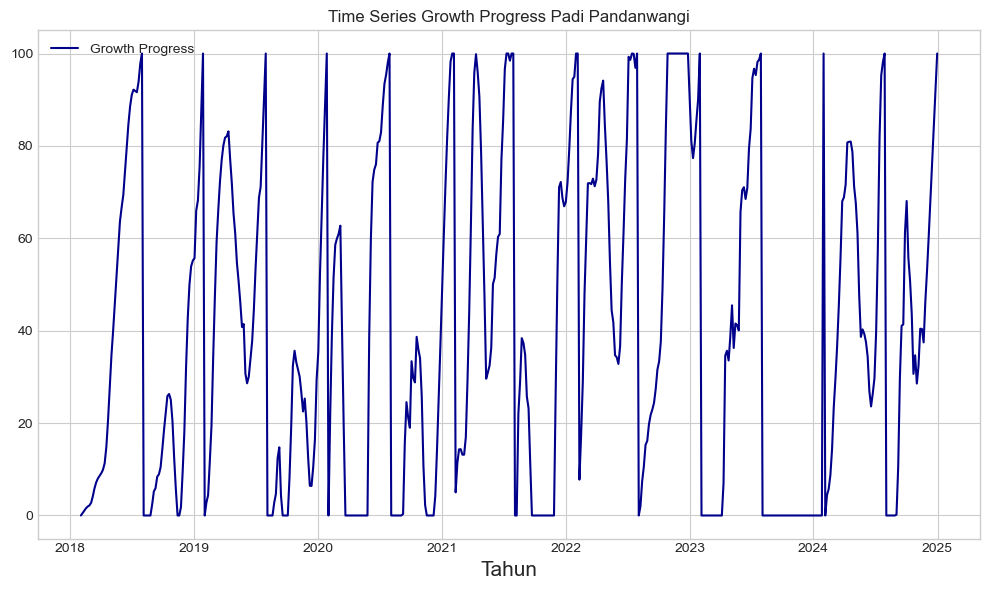

shape for veg_df: (512, 8)
shape for clim_df: (2556, 16)


In [1306]:
# max_month = count_clusters.idxmax()['cluster_id']
max_month = 1
print(max_month)

veg_df = vegetation_preprocessing(raw_veg_df, plant_time_df_pw,month=max_month, grouping=True)
veg_df = veg_df[extract_statistics]
veg_df = smoothing_sg(veg_df, window_length=10, polyorder=3)


clim_df = pd.read_csv(climate_dir)
clim_df = climate_df_processing(clim_df)


veg_df = veg_df[(veg_df.index.year >= start_observe_year) & (veg_df.index.year <= end_observe_year)]
# print(veg_df.index)
clim_df = clim_df[(clim_df.index.year >= start_observe_year) & (clim_df.index.year <= end_observe_year)]

veg_df = growth_progress(veg_df)
plt.figure(figsize=(10, 6))
plt.plot(veg_df.index, veg_df['growth_percent'], label='Growth Progress', color='darkblue')
# plt.plot(veg_df.index, veg_df['smoothed_mean'], label='EVI', color='green', alpha=0.6)

plt.xlabel('Tahun', fontsize=15)
# plt.ylabel('Progress Pertumbuhan %', fontsize=15)
plt.title('Time Series Growth Progress Padi Pandanwangi')
plt.legend()
plt.tight_layout()
plt.savefig(f"{viz_dir}/smoothed_mean.png")
plt.show()

veg_diff = difference_df(veg_df)
clim_diff = difference_df(clim_df)
print("shape for veg_df:", veg_df.shape)
print("shape for clim_df:", clim_df.shape)

## Cek stasioneritas data

In [ ]:
# mengecek stasioneritas pada data dengan Dicky-Fuller test dengan alpha 5%
def test_stationarity(df):
    results = {}
    for col in df.columns:
        adf_result = sm.tsa.stattools.adfuller(df[col].dropna())
        results[col] = {
            'ADF Statistic': adf_result[0],
            'p-value': adf_result[1],
            'Stationary': adf_result[1] < 0.05
        }
    return pd.DataFrame(results).T

print(f"\nStationarity Test for Climate Data ({selected_kec.title()}):")
climate_stationarity = test_stationarity(clim_df)
print(climate_stationarity)

print(f"\nStationarity Test for Vegetation Data ({selected_kec.title()}):")
vegetation_stationarity = test_stationarity(veg_df)
print(vegetation_stationarity)

print(f"\nStationarity Test for Differenced Climate Data ({selected_kec.title()}):")
climate_stationarity = test_stationarity(clim_diff)
print(climate_stationarity)

print(f"\nStationarity Test for Differenced Vegetation Data ({selected_kec.title()}):")
vegetation_stationarity = test_stationarity(veg_diff)
print(vegetation_stationarity)

# Adjust kedua dataset supaya konsisten

In [1307]:
# adjust data agar mempunyai time series yang sama
to_adjust = [veg_df, clim_df]
# to_adjust = [preprocessed_climate, preprocessed_vegetation]
intersecting_idx = to_adjust[0].index.intersection(to_adjust[1].index)
adjusted_veg = pd.DataFrame(to_adjust[0].loc[intersecting_idx].interpolate().bfill().ffill())
adjusted_clim = pd.DataFrame(to_adjust[1].loc[intersecting_idx].interpolate().bfill().ffill())
# print(adjusted_clim)
# print(adjusted_veg)

## Cek korelasi awal dengan lag

In [1308]:
# PARAMS
max_corr_lag = 24
min_corr_lag = 0
used_veg_stats = ['growth_percent']
filter_params = 'growth_percent'

## Functions

In [1107]:
# hitung korelasi dengan lag
def calculate_lagged_correlation(climate_df, vegetation_df, min_lag=0, max_lag=0, veg_stats=None, clim_stats=None, mode='whole', lag_ref=None):
    vegetation_stats = veg_stats if veg_stats is not None else vegetation_df.columns
    
    lag_correlation = {
        'veg_stat': [],
        'cuaca': [],
        'lag': [],
        'correlation': [],
        'p_value': [],
        'observed_year': []
    }

    
    if mode == 'whole':
        for stat in vegetation_stats:
            if stat in vegetation_df.columns:
                veg_series = vegetation_df[stat]
                
                for feature in climate_df.columns:
                    climate_series = climate_df[feature]
                    
                    # hitung cross-correlation pada lag min_lag hingga max_lag (pada time series)
                    for lag in range(min_lag, max_lag+1):
                        
                        x = climate_series.iloc[:-lag].values if lag != 0 else climate_series.values
                        y = veg_series.iloc[lag:].values if lag != 0 else veg_series.values
                        
                        corr, p_value = stats.pearsonr(x, y)
                        
                        lag_correlation['veg_stat'].append(stat)
                        lag_correlation['cuaca'].append(feature)
                        lag_correlation['lag'].append(lag)
                        lag_correlation['correlation'].append(corr)
                        lag_correlation['p_value'].append(p_value)
                        lag_correlation['observed_year'].append(f"{start_observe_year}-{end_observe_year}")
    elif mode =='pandanwangi':
        for year in np.arange(start_observe_year, end_observe_year + 0.5, 0.5):
            real_year = int(year)
            start_month = (year-real_year) * 12
            end_month = start_month + 6

            for stat in vegetation_stats:
                if stat in vegetation_df.columns:
                    veg_series = vegetation_df[stat]
                    veg_pw = veg_series[(veg_series.index.year == real_year) & (veg_series.index.month >= start_month) & (veg_series.index.month <= end_month)]

                    
                    for feature in climate_df.columns:
                        if lag_ref is not None:
                            curr_lag = lag_ref[lag_ref['cuaca'] == feature]
                            curr_lag = curr_lag[curr_lag['observed_year'] == year]
                            min_lag = curr_lag['lag'].iloc[0]
                            max_lag = curr_lag['lag'].iloc[0]
                        climate_series = climate_df[feature]
                        clim_pw = climate_series[(climate_series.index.year == real_year) & (climate_series.index.month >= start_month) & (climate_series.index.month <= end_month)]
                    
                        
                        # hitung cross-correlation pada lag min_lag hingga max_lag (pada time series)
                        for lag in range(min_lag, max_lag+1):
                            
                            x = veg_pw.iloc[:-lag].values if lag != 0 else climate_series.values
                            y = clim_pw.iloc[lag:].values if lag != 0 else veg_series.values
                            
                            corr, p_value = stats.pearsonr(x, y)
                            
                            lag_correlation['veg_stat'].append(stat)
                            lag_correlation['cuaca'].append(feature)
                            lag_correlation['lag'].append(lag)
                            lag_correlation['correlation'].append(corr)
                            lag_correlation['p_value'].append(p_value)
                            lag_correlation['observed_year'].append(year)
    return pd.DataFrame(lag_correlation)

In [1078]:
def growth_climate_plot(climate_df, vegetation_df, clim_stat, lag_ref, veg_stat='growth_percent'):    
    
    plotting = {veg_stat: [],
               clim_stat: []}
    
    
    for year in np.arange(start_observe_year, end_observe_year + 0.5, 0.5):
        
        real_year = int(year)
        start_month = (year-real_year) * 12
        end_month = start_month + 6
        
        curr_lag = lag_ref[lag_ref['cuaca'] == clim_stat]
        curr_lag = curr_lag[curr_lag['observed_year'] == year]
        lag = curr_lag['lag'].iloc[0]
        
        veg_series = vegetation_df[veg_stat]
        veg_pw = veg_series[(veg_series.index.year == real_year) & (veg_series.index.month >= start_month) & (veg_series.index.month <= end_month)]
        
        
        climate_series = climate_df[clim_stat]
        clim_pw = climate_series[(climate_series.index.year == real_year) & (climate_series.index.month >= start_month) & (climate_series.index.month <= end_month)]
    
            
        x = veg_pw.iloc[:-lag].values if lag != 0 else climate_series.values
        y = clim_pw.iloc[lag:].values if lag != 0 else veg_series.values

        plotting[veg_stat].append(x)
        plotting[clim_stat].append(y)

    return pd.DataFrame(plotting)

## Hitung Korelasi

## Keseluruhan

In [ ]:
# hitung korelasi dengan faktor lag hingga max_corr_lag
print(f"\nLagged correlations for {selected_kec.title()}")
lag_corr_df = calculate_lagged_correlation(
    adjusted_clim, 
    adjusted_veg, 
    min_lag=min_corr_lag,
    max_lag=max_corr_lag,
    veg_stats=used_veg_stats,
    mode='whole' # whole, yearly, or pandanwangi
)
results = lag_corr_df
# print(results)
significant = results[results['p_value'] < 0.05]

max_each_combination = results.loc[results.groupby(['veg_stat', 'cuaca'])['correlation'].apply(lambda x: x.abs().idxmax())]
max_each_combination = max_each_combination.reindex(max_each_combination['correlation'].abs().sort_values(ascending=False).index)

print(max_each_combination.shape)
    

if filter_params is not None:
    max_each_combination = max_each_combination[max_each_combination['veg_stat'] == filter_params]

strong_correlations = max_each_combination[max_each_combination['correlation'].abs() >= 0.5]
print(f"\nTop 20 strongest correlations for {selected_kec.title()}:")
print(max_each_combination[['veg_stat', 'cuaca', 'correlation', 'lag', 'observed_year']])    

# if strong_correlations.shape[0] == 0:
#     print(max_each_combination[['veg_stat', 'cuaca', 'correlation', 'lag', 'observed_year']].head(20))    
# else:
#     print(strong_correlations[['veg_stat', 'cuaca', 'correlation', 'lag', 'observed_year']].head(20))

print(f"\nStrong correlations distribution:")
print(strong_correlations.groupby(['veg_stat', 'cuaca'])['observed_year'].count())

avg_correlation_by_weather = max_each_combination.groupby('cuaca')['correlation'].mean().sort_values(ascending=False)
print("Rata-rata korelasi per variabel cuaca:")
print(avg_correlation_by_weather)

## Siklus 6 bulanan

In [1309]:
# hitung korelasi dengan faktor lag hingga max_corr_lag
print(f"\nLagged correlations for {selected_kec.title()}")
lag_corr_df = calculate_lagged_correlation(
    adjusted_clim, 
    adjusted_veg, 
    min_lag=min_corr_lag,
    max_lag=max_corr_lag,
    veg_stats=used_veg_stats,
    mode='pandanwangi', # whole, yearly, or pandanwangi
)
results = lag_corr_df
# print(results)
significant = results[results['p_value'] < 0.05]

max_each_combination = results.loc[results.groupby(['veg_stat', 'cuaca', 'observed_year'])['correlation'].apply(lambda x: x.abs().idxmax())]
max_each_combination = max_each_combination.reindex(max_each_combination['correlation'].abs().sort_values(ascending=False).index)

abs_correlation_all = max_each_combination.copy()
abs_correlation_all['correlation'] = abs_correlation_all['correlation'].abs()

all_cycle_mean = max_each_combination.groupby(['cuaca'])['correlation'].mean()
# print(max_each_combination[['veg_stat', 'cuaca', 'correlation', 'lag', 'observed_year']])    

abs_cycle_mean = abs_correlation_all.groupby(['cuaca'])['correlation'].mean()
# print(max_each_combination[['veg_stat', 'cuaca', 'correlation', 'lag', 'observed_year']])    


if filter_params is not None:
    max_each_combination = max_each_combination[max_each_combination['veg_stat'] == filter_params]

strong_correlations = max_each_combination[max_each_combination['correlation'].abs() >= 0.5]
print(f"All Cycle Mean")
print(all_cycle_mean)    

print(f"Abs Cycle Mean")
print(abs_cycle_mean)    

# if strong_correlations.shape[0] == 0:
#     print(max_each_combination[['veg_stat', 'cuaca', 'correlation', 'lag', 'observed_year']].head(20))    
# else:
#     print(strong_correlations[['veg_stat', 'cuaca', 'correlation', 'lag', 'observed_year']].head(20))

print(f"\nStrong correlations distribution:")
print(strong_correlations.shape)
strong_counts = strong_correlations.groupby(['veg_stat', 'cuaca'])['observed_year'].count()
strong_counts = (strong_counts / ((end_observe_year-start_observe_year+1) *2)) * 100
print(strong_counts)


Lagged correlations for Cibeber
All Cycle Mean
cuaca
dewpoint_temperature_2m                 -0.324902
soil_temperature_level_1                 0.281239
soil_temperature_level_2                 0.446017
surface_net_solar_radiation_sum          0.162894
surface_solar_radiation_downwards_sum    0.231547
temperature_2m                           0.246064
temperature_2m_max                       0.328652
temperature_2m_min                      -0.150558
temperature_range                        0.228915
total_evaporation_sum                    0.168796
total_precipitation_sum                 -0.128530
u_component_of_wind_10m                 -0.328176
v_component_of_wind_10m                 -0.271415
volumetric_soil_water_layer_1           -0.379444
volumetric_soil_water_layer_2           -0.420479
volumetric_soil_water_layer_3           -0.466557
Name: correlation, dtype: float64
Abs Cycle Mean
cuaca
dewpoint_temperature_2m                  0.603083
soil_temperature_level_1                 

## Pencarian Nilai Optimal

## Function

In [1141]:
def growth_climate_plot(climate_df, vegetation_df, clim_stat, lag_ref, veg_stat='growth_percent'):    
    
    plotting = {veg_stat: [],
               clim_stat: []}
    
    
    for year in np.arange(start_observe_year, end_observe_year + 0.5, 0.5):
        
        real_year = int(year)
        start_month = (year-real_year) * 12
        end_month = start_month + 6
        
        curr_lag = lag_ref[lag_ref['cuaca'] == clim_stat]
        curr_lag = curr_lag[curr_lag['observed_year'] == year]
        lag = curr_lag['lag'].iloc[0]
        
        veg_series = vegetation_df[veg_stat]
        veg_pw = veg_series[(veg_series.index.year == real_year) & (veg_series.index.month >= start_month) & (veg_series.index.month <= end_month)]
        
        
        climate_series = climate_df[clim_stat]
        clim_pw = climate_series[(climate_series.index.year == real_year) & (climate_series.index.month >= start_month) & (climate_series.index.month <= end_month)]
    
            
        x = veg_pw.iloc[:-lag].values if lag != 0 else climate_series.values
        y = clim_pw.iloc[lag:].values if lag != 0 else veg_series.values

        for sub_x in x:
            plotting[veg_stat].append(sub_x)
        for sub_y in y:
            plotting[clim_stat].append(sub_y)

    return pd.DataFrame(plotting)

## Implementasi

In [1310]:
# lag reference
lag_reference = max_each_combination[['cuaca','observed_year', 'lag']]
# print(lag_reference)

In [1315]:
to_adjust = [veg_diff, clim_df]
# to_adjust = [preprocessed_climate, preprocessed_vegetation]
intersecting_idx = to_adjust[0].index.intersection(to_adjust[1].index)
adjusted_veg = pd.DataFrame(to_adjust[0].loc[intersecting_idx].interpolate().bfill().ffill())
adjusted_clim = pd.DataFrame(to_adjust[1].loc[intersecting_idx].interpolate().bfill().ffill())

# print(adjusted_veg)

pilih_aja = ['dewpoint_temperature_2m', 'temperature_2m', 'volumetric_soil_water_layer_3', 'soil_temperature_level_2', 'u_component_of_wind_10m',
            'relative_humidity', 'temperature_range', 'surface_net_solar_radiation_sum']
pilih_label = ['Titik Pengembunan', 'Temperatur Udara', 'Volume Air Dalam Tanah', 'Temperatur Tanah', 'Kecepatan Angin (Barat-Timur)', 
               'Kelembapan Udara', 'Rentang Temperatur', 'Intensitas radiasi matahari']
pilihan=2

clim_stat = pilih_aja[pilihan]
clim_label = pilih_label[pilihan]
growth_clim_df = growth_climate_plot(adjusted_clim, adjusted_veg, clim_stat, lag_reference)

def clean_outliers(df):
    # buang outliers
    q1 = df['growth_percent'].quantile(0.25)
    q3 = df['growth_percent'].quantile(0.75)
    IQR = q3 - q1
    
    lower_bound = q1 - 1.5 * IQR
    upper_bound = q3 + 1.5 * IQR

    no_outliers = df[
        (df['growth_percent'] >= lower_bound) &
        (df['growth_percent'] <= upper_bound)
    ]

    return no_outliers

print(growth_clim_df)

     growth_percent  volumetric_soil_water_layer_3
0          0.524483                       0.483349
1          0.524483                       0.508814
2          0.524483                       0.511124
3          0.524483                       0.486737
4          0.524483                       0.492619
..              ...                            ...
268        0.164746                       0.427700
269        0.037085                       0.420183
270       -2.235879                       0.413179
271       -7.478466                       0.403310
272       -3.566731                       0.402113

[273 rows x 2 columns]


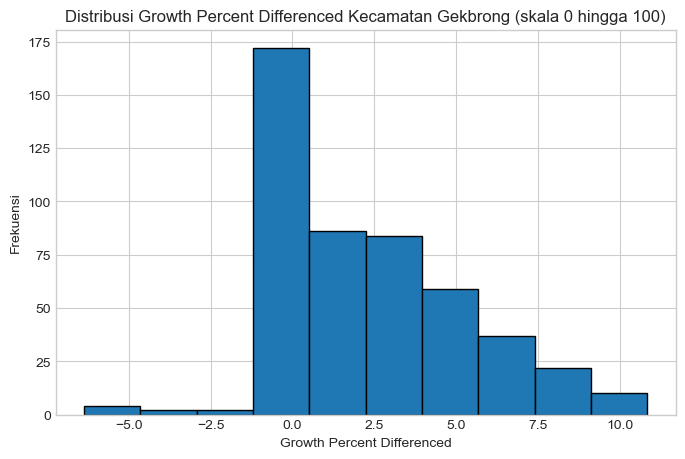

In [1218]:
no_outliers = clean_outliers(adjusted_veg)

num_bins = 10
plt.figure(figsize=(8, 5))
plt.hist(no_outliers['growth_percent'], bins=num_bins, edgecolor='black')

plt.title(f'Distribusi Growth Percent Differenced Kecamatan {selected_kec.title()} (skala 0 hingga 100)')
plt.xlabel('Growth Percent Differenced')
plt.ylabel('Frekuensi')
plt.grid(True)
plt.savefig('nilai_optimal_viz/temp_growth_hist')
plt.show()


(243, 2)
(107, 2)


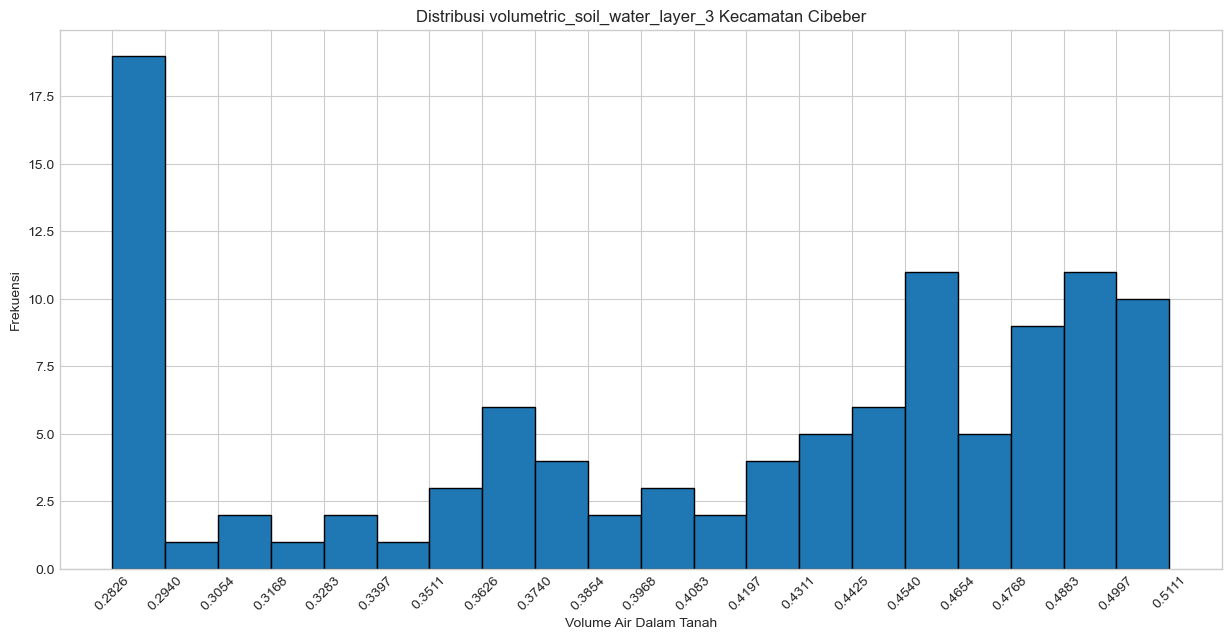

In [1316]:
no_outliers = clean_outliers(growth_clim_df)
print(no_outliers.shape)
no_outliers = no_outliers[no_outliers['growth_percent'] >= 2.8]
print(no_outliers.shape)



num_bins = 20
plt.figure(figsize=(15, 7))

# Plot histogram
plt.hist(no_outliers[clim_stat], bins=num_bins, edgecolor='black')

# Judul dan label
plt.title(f'Distribusi {clim_stat} Kecamatan {selected_kec.title()}')
plt.xlabel(clim_label)
plt.ylabel('Frekuensi')
plt.grid(True)

# Membuat X ticks continuous
min_val = no_outliers[clim_stat].min()
max_val = no_outliers[clim_stat].max()
xticks = np.linspace(min_val, max_val, num=21)  # atau ganti jumlah ticks jika perlu
plt.xticks(xticks, rotation=45)

# Simpan dan tampilkan
plt.savefig(f'nilai_optimal_viz/{selected_kec}_{clim_stat}')
plt.show()


# Scatterplot

In [ ]:
plt.figure(figsize=(8, 5))
param_cuaca = 'volumetric_soil_water_layer_1'
filtered = results[results['cuaca']==param_cuaca]
filtered = filtered[filtered['observed_year'] % 1 != 0]
correlations = filtered['correlation']
lags = filtered['lag'] * 5
plt.scatter(lags, correlations, s=20, alpha=0.7)

print(stats.pearsonr(correlations, lags)[0])
plt.xlabel('Lag', fontsize=14)
plt.ylabel('Correlation', fontsize=14)
plt.title(f'Scatter Plot of Correlation vs Lag {param_cuaca}')
plt.grid(True)
plt.savefig(f'{viz_dir}/scatterplot corr_lag')
plt.show()

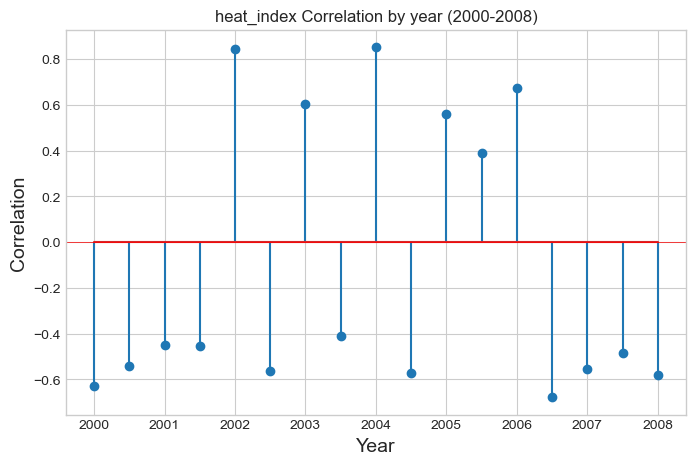

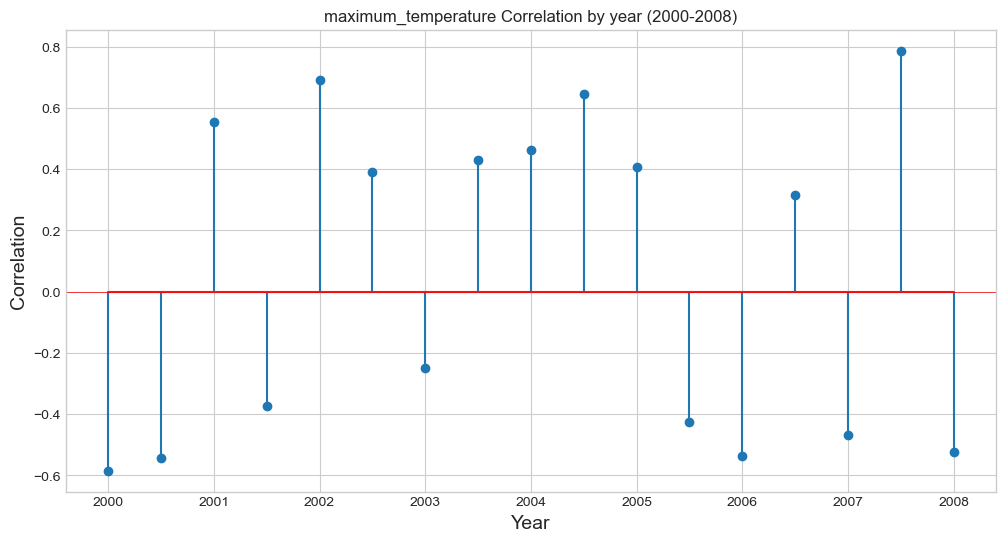

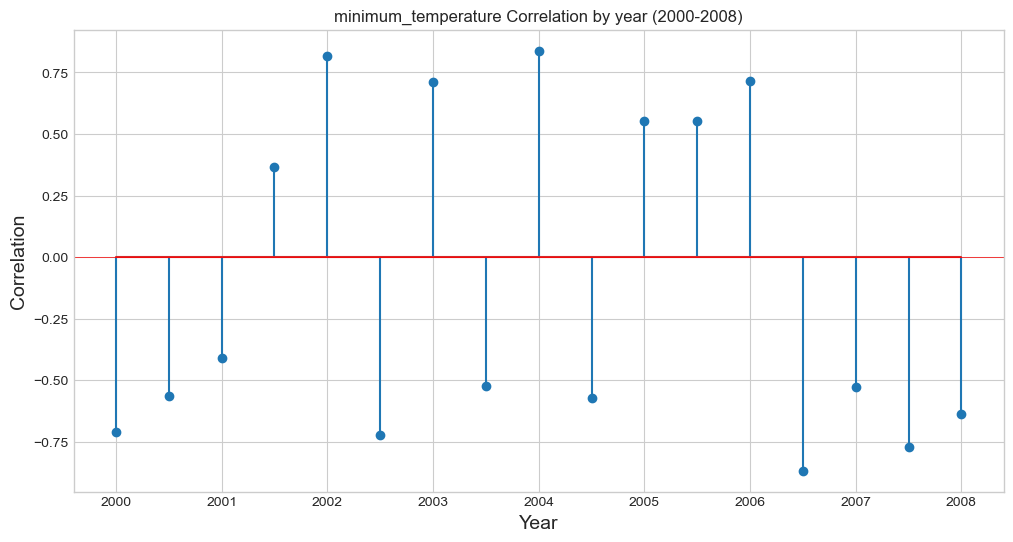

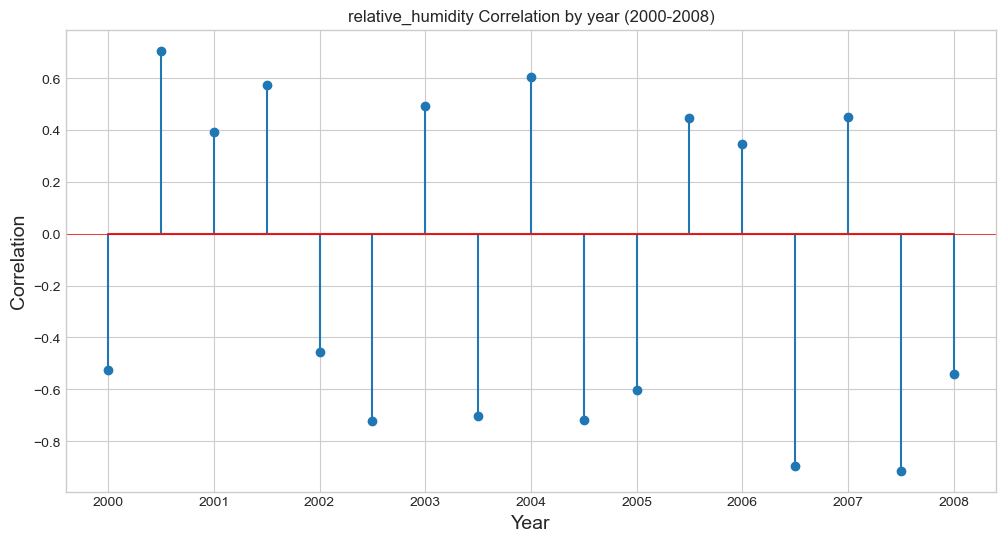

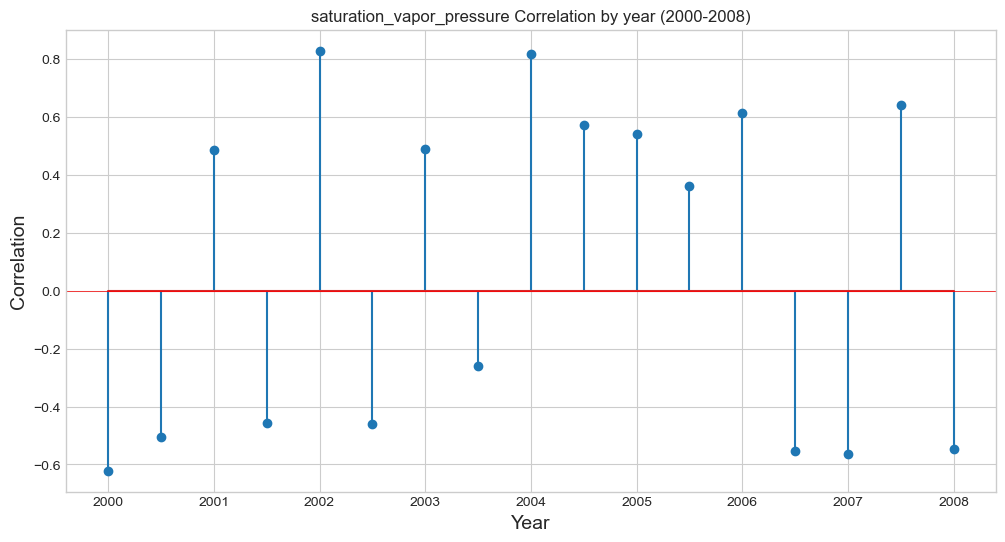

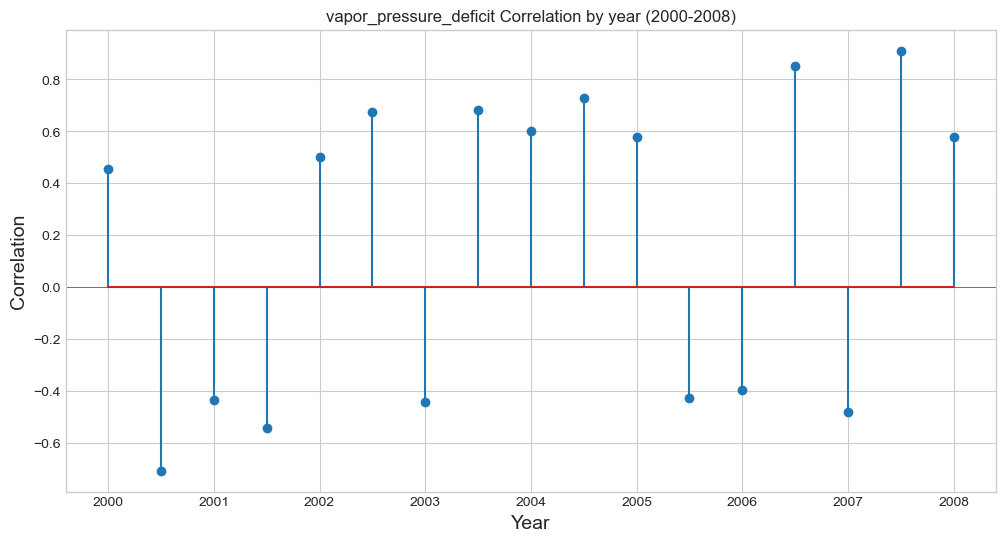

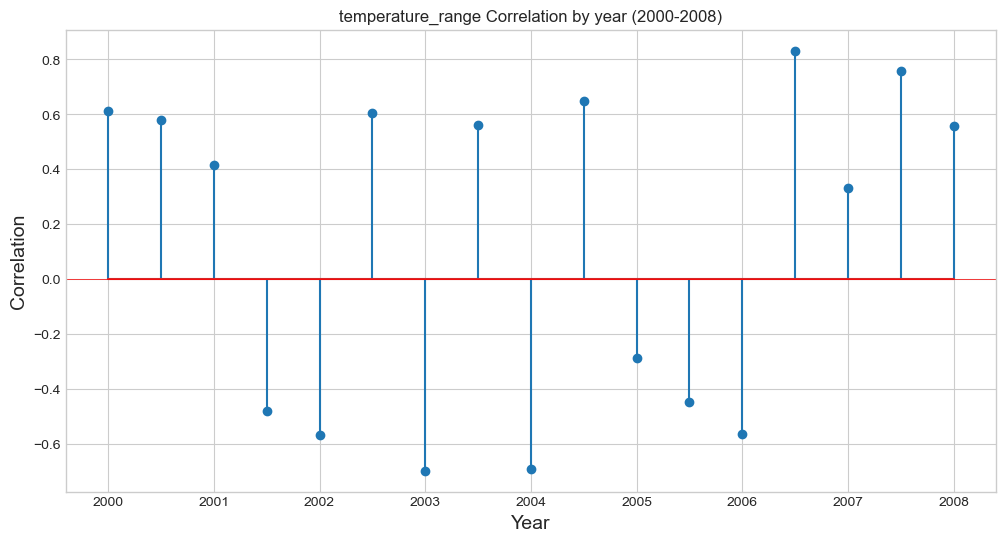

In [1048]:
plt.figure(figsize=(8, 5))
if 'temperature_range' not in selected_features:
    selected_features.append('temperature_range')
for feature in selected_features:
    param_cuaca = feature
    filtered = max_each_combination[max_each_combination['cuaca']==param_cuaca].sort_values('observed_year')
    correlations = filtered['correlation']
    year = filtered['observed_year']
    # print(correlations)
    # print(year)
    # plt.plot(year, correlations, marker='o', linestyle='-', color='blue', alpha=0.7)
    plt.stem(year, correlations)
    
    # print(stats.pearsonr(correlations, lags)[0])
    plt.xlabel('Year', fontsize=14)
    plt.ylabel('Correlation', fontsize=14)
    plt.title(f'{param_cuaca} Correlation by year ({start_observe_year}-{end_observe_year})')
    plt.axhline(0, color='red', linewidth=0.5)
    plt.grid(True)
    plt.savefig(f'{viz_dir}/cibeber_chirts_{feature}')
    plt.show()

# Visualisasi

## Functions

In [ ]:
def plot_correlation_heatmap_single(lag_corr_df):
    # lag_subset = lag_corr_df[lag_corr_df['lag'] == lag]
    lag_subset = lag_corr_df
    lag_subset['lag'] = lag_subset['lag'] * 5
    # print(lag_subset)
    # Prepare data for heatmap
    plt.figure(figsize=(8, 8))  # misalnya 6 inches wide, 8 inches tall

    pivot_data = lag_subset.pivot_table(
        index='cuaca', 
        columns='veg_stat', 
        values='correlation'
    )

    # print(pivot_data)
    
    # Create heatmap
    sns.heatmap(pivot_data, annot=True, cmap='coolwarm', center=0, 
                vmin=-1, vmax=1, fmt='.2f')
    
    plt.title(f'Heatmap Korelasi', fontsize=15)
    plt.xlabel(f'Rata-rata EVI {selected_kec.title()} {start_observe_year if start_observe_year == end_observe_year else f"{start_observe_year}-{end_observe_year}"}', fontsize=12)
    plt.ylabel(f'Faktor Cuaca {selected_clim.upper()}', fontsize=12)
    plt.tight_layout()
    plt.savefig(f'{viz_dir}correlation_heatmap_{selected_kec}')
    plt.show()
    plt.close()

# Function Visualisasi
def plot_correlation_heatmap(lag_corr_df):
    lag_subset = lag_corr_df
    lag_subset['lag'] = lag_subset['lag'] * 5
    # Buat pivot table terpisah untuk correlation dan lag
    corr_pivot = lag_subset.pivot_table(
        index='cuaca', 
        columns='veg_stat', 
        values='correlation'
    )
    
    lag_pivot = lag_subset.pivot_table(
        index='cuaca', 
        columns='veg_stat', 
        values='lag'
    )
    
    # Buat subplot dengan 2 kolom
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Heatmap untuk correlation
    sns.heatmap(corr_pivot, 
                annot=True, 
                cmap='coolwarm', 
                center=0,
                vmin=-1, vmax=1, 
                fmt='.2f',
                ax=ax1
                )
    
    ax1.set_title('Korelasi Cuaca-Vegetasi', fontsize=14, fontweight='bold')
    ax1.set_xlabel(f'Nilai Korelasi', fontsize=12)
    ax1.set_ylabel(f'Parameter Cuaca', fontsize=12)
    
    # Heatmap untuk lag dengan warna putih-abu
    sns.heatmap(lag_pivot, 
                annot=True, 
                cmap='Greys',  # Colormap putih ke abu-abu
                fmt='',       # Format integer untuk lag
                ax=ax2,
                cbar_kws={'label': 'Lag (days)'})
    
    ax2.set_title('Lag Waktu Optimal', fontsize=14, fontweight='bold')
    ax2.set_xlabel(f'Jumlah Lag', fontsize=12)
    ax2.set_ylabel(f'', fontsize=12)
    
    plt.tight_layout()
    plt.savefig(f'{viz_dir}correlation_heatmap_{selected_kec}', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

# Alternatif: Jika ingin tetap satu heatmap dengan annotasi custom
def plot_combined_heatmap(lag_corr_df):
    lag_subset = lag_corr_df
    lag_subset['lag'] = lag_subset['lag'] * 5

    # Pivot hanya untuk correlation
    corr_pivot = lag_subset.pivot_table(
        index='cuaca', 
        columns='veg_stat', 
        values='correlation'
    )
    
    # Pivot untuk lag (akan digunakan untuk annotasi)
    lag_pivot = lag_subset.pivot_table(
        index='cuaca', 
        columns='veg_stat', 
        values='lag'
    )
    
    # Buat custom annotation yang menggabungkan correlation dan lag
    annot_array = []
    for i in range(len(corr_pivot.index)):
        row = []
        for j in range(len(corr_pivot.columns)):
            corr_val = corr_pivot.iloc[i, j]
            lag_val = int(lag_pivot.iloc[i, j])
            # Format: correlation value \n (lag: X months)
            annotation = f"{corr_val:.2f}\(lag: {lag_val})"
            row.append(annotation)
        annot_array.append(row)
    
    plt.figure(figsize=(10, 8))
    
    # Heatmap dengan custom annotation
    sns.heatmap(corr_pivot, 
                annot=annot_array,  # Custom annotation array
                fmt='',             # Empty format karena pakai custom
                cmap='coolwarm', 
                center=0,
                vmin=-1, 
                vmax=1
               )
    
    plt.title(f'Korelasi dan Lag Cuaca-Vegetasi\n{selected_kec.title()} {start_observe_year if start_observe_year == end_observe_year else f"{start_observe_year}-{end_observe_year}"}', 
              fontsize=15, fontweight='bold')
    plt.xlabel(f'Nilai Korelasi', fontsize=12)
    plt.ylabel(f'Parameter Cuaca ({selected_clim.upper()})', fontsize=12)
    
    plt.tight_layout()
    plt.savefig(f'{viz_dir}correlation_heatmap_{selected_kec}', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()


## Viz

In [ ]:
plot_correlation_heatmap_single(max_each_combination)

In [ ]:
plot_correlation_heatmap(max_each_combination)

In [ ]:
plot_combined_heatmap(max_each_combination)

In [ ]:
def plot_ccf(x, y, max_lag=60):
    x = (x - np.mean(x)) / np.std(x)
    y = (y - np.mean(y)) / np.std(y)

    lags = np.arange(0, max_lag + 1)
    ccf_vals = [np.corrcoef(x[max_lag:-max_lag], np.roll(y, lag)[max_lag:-max_lag])[0, 1] for lag in lags]

    plt.figure(figsize=(10, 4))
    plt.stem(lags, ccf_vals)
    plt.title('Cross-correlation vs Lag')
    plt.xlabel('Lag (days)')
    plt.ylabel('Correlation')
    plt.axhline(0, color='black', linewidth=0.5)
    plt.grid(True)
    plt.show()

# Contoh pemanggilan
plot_ccf(adjusted_veg['smoothed_mean'], adjusted_clim['temperature_2m'], max_lag=100)